# Tensorflow Object Detection Inference


In [1]:
!pip install -U --pre tensorflow=="2.2.0"

     |████████████████████████████████| 516.2MB 29kB/s 
     |████████████████████████████████| 3.0MB 40.5MB/s 
     |████████████████████████████████| 460kB 33.7MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


## Install Object Detection API

In [2]:
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2454, done.
remote: Counting objects: 100% (2454/2454), done.
remote: Compressing objects: 100% (2052/2052), done.
remote: Total 2454 (delta 598), reused 1236 (delta 375), pack-reused 0
Receiving objects: 100% (2454/2454), 30.85 MiB | 29.69 MiB/s, done.
Resolving deltas: 100% (598/598), done.


In [3]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1627760 sha256=8afcf68e2e553ae658b26fb7aef166efbe2539fb4ee913ec2cfe941fd051d03d
  Stored in directory: /tmp/pip-ephem-wheel-cache-19ge0128/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.2-cp37-none-any.whl size=44011 sha256=98179d705be0de3d3b22e766b007bf9a06d03da043594dd1e1dfafb8e8fb35db
  Stored in directory: /root/.cache/pip/wheels/ee/ee/18/c466221ca6900e3efce2f4ea9c329288808679aecdcb2838d3
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78532 sha256=f913b585eba28bea663fa4b74ffa36e0cd2dc37dd29005798c0430fda36028d1
  Stored in directory: /root/.cache/pip/wheels/59/b1/91/f02e76c732915c4015ab4010f3015469866c1eb9b14058d8e7
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=b08d1f0e8f93fa89821a88d40d8472a5c518b34a7fa63b96f5eb

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.28.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.


## Imports and setup

In [30]:
import os
import io
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import time

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from object_detection.utils import label_map_util, config_util
from object_detection.utils import visualization_utils as viz_utils

%matplotlib inline
# import warnings
# warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

## Connect with drive

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load model

In [13]:
ROOT = 'gdrive/MyDrive/flores/MIA1'
PATH_TO_FROZEN_GRAPH = os.path.join(ROOT, 'models', 'saved_model', 'op1', 'frozen_inference_graph.pb')
PATH_TO_LABELS = os.path.join(ROOT, 'flowers_label_map.pbtxt')

print('Model path {}'.format(PATH_TO_FROZEN_GRAPH))
print('Label path {}'.format(PATH_TO_LABELS))

Model path gdrive/MyDrive/flores/MIA1/models/saved_model/op1/frozen_inference_graph.pb
Label path gdrive/MyDrive/flores/MIA1/flowers_label_map.pbtxt


In [23]:
# Load saved model and build the detection function
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
print('Model loaded')

Model loaded


## Load label map

In [17]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
category_index

{1: {'id': 1, 'name': 'np'},
 2: {'id': 2, 'name': 'P1'},
 3: {'id': 3, 'name': 'P1_1'},
 4: {'id': 4, 'name': 'P1_2'},
 5: {'id': 5, 'name': 'P1_falsos'},
 6: {'id': 6, 'name': 'P2'},
 7: {'id': 7, 'name': 'P2_1'},
 8: {'id': 8, 'name': 'P3'},
 9: {'id': 9, 'name': 'P3_1'},
 10: {'id': 10, 'name': 'P4'},
 11: {'id': 11, 'name': 'P5'},
 12: {'id': 12, 'name': 'P5_1'},
 13: {'id': 13, 'name': 'P6'},
 14: {'id': 14, 'name': 'P7'},
 15: {'id': 15, 'name': 'P8'}}

## Run detections

In [18]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  return np.array(Image.open(path))

In [43]:
IMAGES_FOLDER = os.path.join(ROOT, 'data', 'Images')
TARGET_FOLDER = os.path.join(ROOT, 'data', 'GenAnnotations')
images_list = os.listdir(IMAGES_FOLDER)
print('Images folder: {}'.format(IMAGES_FOLDER))
print('Found: {}'.format(len(images_list)))

Images folder: gdrive/MyDrive/flores/MIA1/data/Images
Found: 128


In [24]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

1/128. Running inference for DJI_0210.JPG


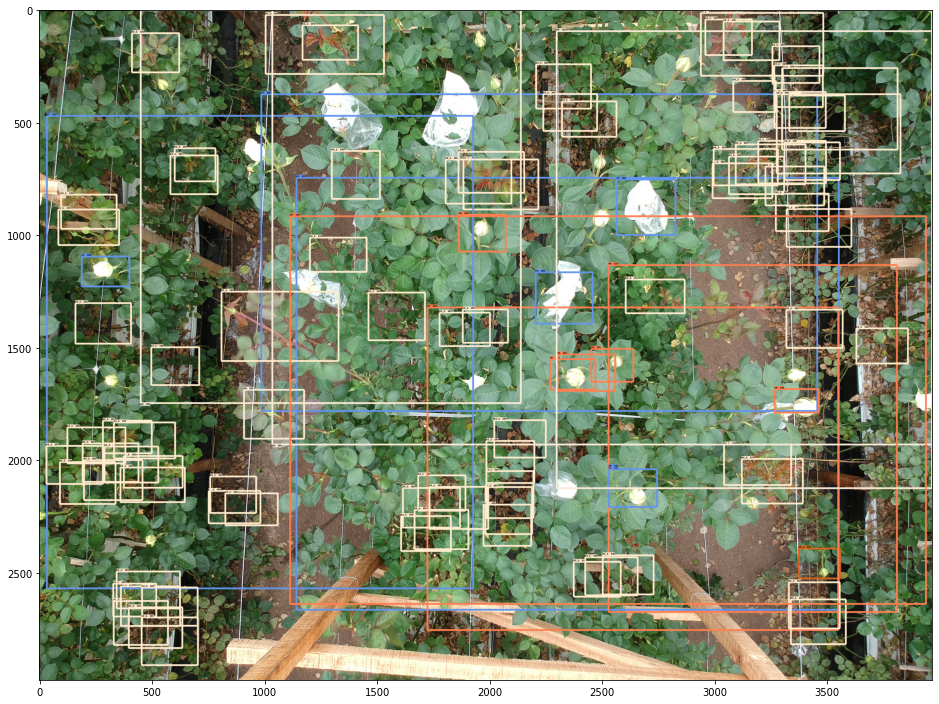

In [33]:
for idx, image_name in enumerate(images_list):
  print('{}/{}. Running inference for {}'.format(idx + 1, len(images_list), image_name))
  image_np = load_image_into_numpy_array(os.path.join(IMAGES_FOLDER, image_name))
    
  # run detections
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  
  image_np_with_detections = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      max_boxes_to_draw=100,
      min_score_thresh=.03,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  
  plt.figure(figsize=(16, 20))
  plt.imshow(image_np_with_detections)
  # analyze only one image
  break
plt.show()

## Create XML

In [39]:
from lxml import etree
import xml.etree.ElementTree as ET

In [48]:
for idx, image_name in enumerate(images_list):
  print('{}/{}. Running inference for {}'.format(idx + 1, len(images_list), image_name))
  image_np = load_image_into_numpy_array(os.path.join(IMAGES_FOLDER, image_name))
  image_id = image_name.split('.')[0]
  
  # run detections
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  height, width, channels = image_np.shape
  scores = output_dict['detection_scores']
  detected_objects = output_dict['detection_classes']
  
  annotation = ET.Element("annotation")
  ET.SubElement(annotation, "folder").text = "Images"
  ET.SubElement(annotation, "filename").text = image_id
  ET.SubElement(annotation, "path").text = os.path.join(IMAGES_FOLDER, image_name)

  source = ET.SubElement(annotation, "source")
  ET.SubElement(source, "database").text = "Unknown"

  size = ET.SubElement(annotation, "size")
  ET.SubElement(size, "width").text = str(width)
  ET.SubElement(size, "height").text = str(height)
  ET.SubElement(size, "depth").text = str(channels)
  ET.SubElement(annotation, "segmented").text = "0"
  
  threshold = 0.03
  for i in range(len(scores)):
    if scores[i] >= threshold:
      name_object = category_index[detected_objects[i]]['name']
      [ymin, xmin, ymax, xmax] = output_dict['detection_boxes'][i]
      xmin = int(xmin * width)
      xmax = int(xmax * width)
      ymin = int(ymin * height)
      ymax = int(ymax * height)
      
      object_annotation = ET.SubElement(annotation, "object")
      ET.SubElement(object_annotation, "name").text = name_object
      ET.SubElement(object_annotation, "pose").text = "Unspecified"
      ET.SubElement(object_annotation, "truncated").text = "0"
      ET.SubElement(object_annotation, "difficult").text = "0"
      bndbox = ET.SubElement(object_annotation, "bndbox")
      ET.SubElement(bndbox, "xmin").text = str(xmin)
      ET.SubElement(bndbox, "ymin").text = str(ymin)
      ET.SubElement(bndbox, "xmax").text = str(xmax)
      ET.SubElement(bndbox, "ymax").text = str(ymax)
  
  tree = ET.ElementTree(annotation)
  root = tree.getroot()
  xmlstr = ET.tostring(root, encoding='utf8', method='xml')

  tree.write(os.path.join(TARGET_FOLDER, image_id + '.xml'))
  # analyze only one image
  break
plt.show()

1/128. Running inference for DJI_0210.JPG
